# Time series forecasting

# Initial setup

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('airline-passenger-traffic.csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


# Time series analysis

## Plot time series data

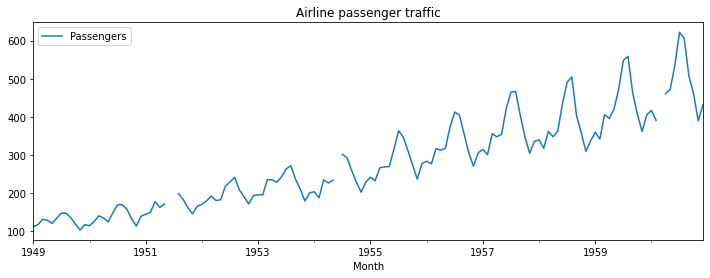

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

## Missing value treatment

### Mean imputation

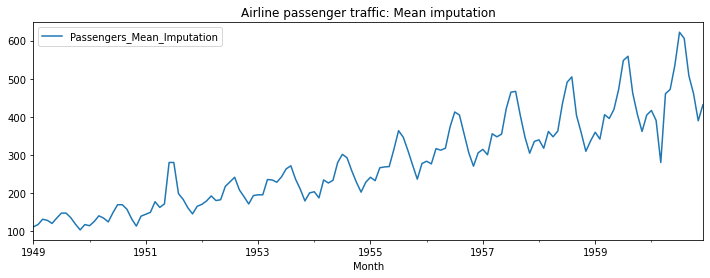

In [4]:
data = data.assign(Passengers_Mean_Imputation=data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Mean imputation')
plt.show(block=False)

### Linear interpolation

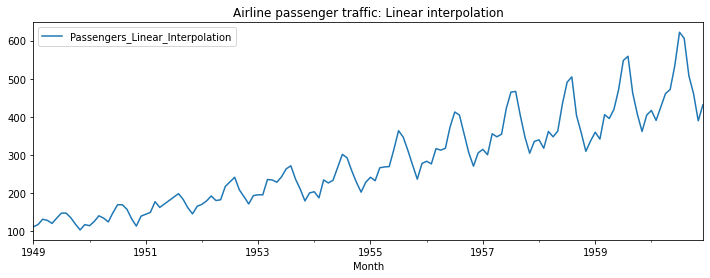

In [5]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

### Use linear interpolation to impute missing values

In [6]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)

## Outlier detection

### Box plot and interquartile range

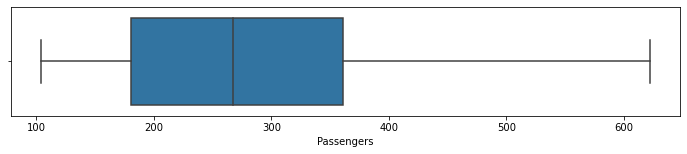

In [7]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Passengers'],whis=1.5)

### Histogram plot

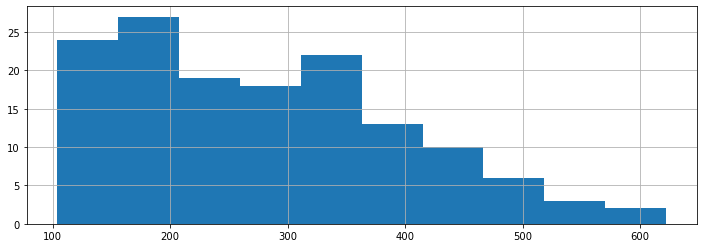

In [8]:
fig = data.Passengers.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

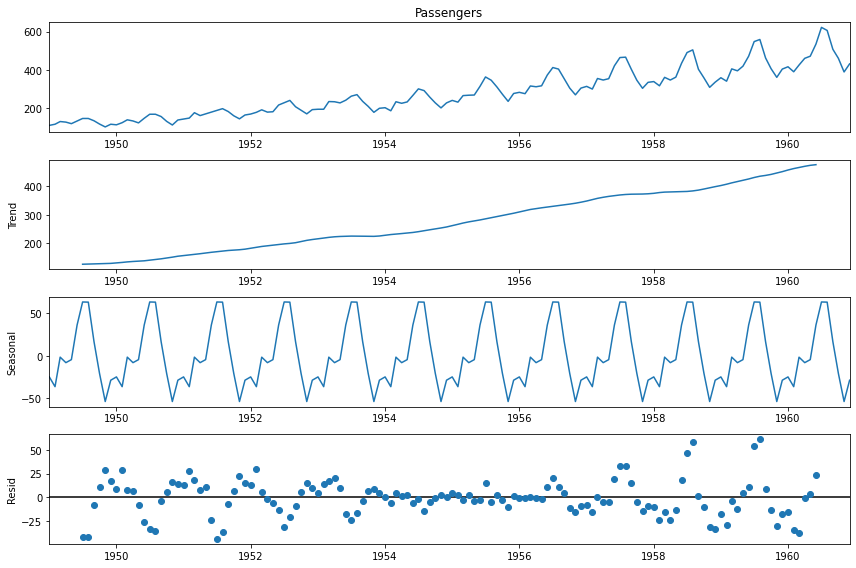

In [9]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

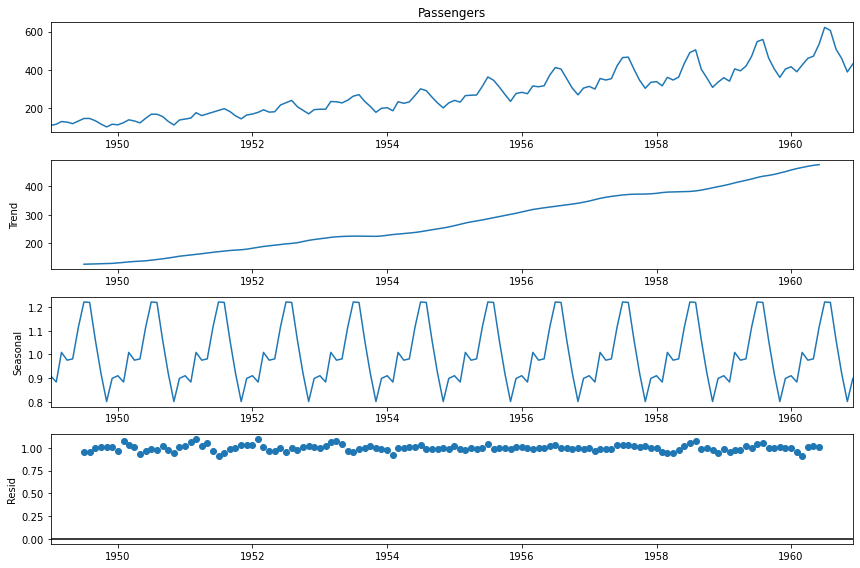

In [10]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

# Build and evaluate time series forecast

## Split time series data into training and test set

In [11]:
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

# Simple time series methods

## Naive method

In [12]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

### Plot train, test and forecast

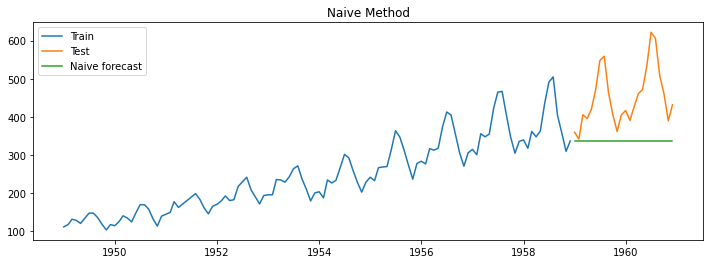

In [13]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63


## Simple average method

In [15]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

### Plot train, test and forecast

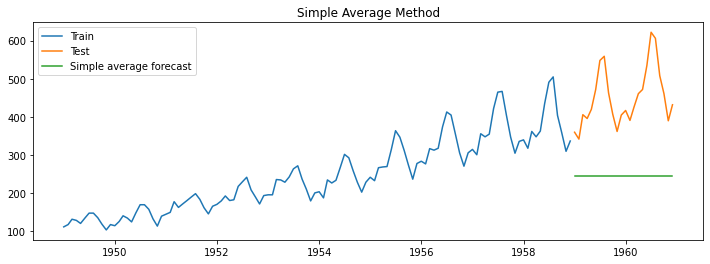

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate RMSE and MAPE

In [17]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28


## Simple moving average method

In [18]:
y_hat_sma = data.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

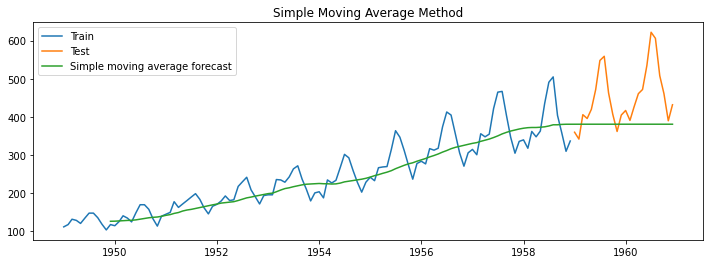

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [20]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54


# Exponential smoothing methods

## Simple exponential smoothing

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Plot train, test and forecast

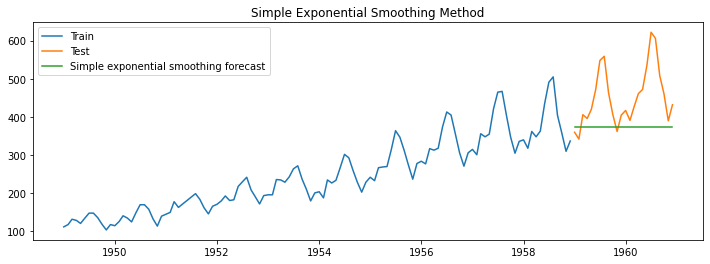

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [23]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49


## Holt's method with trend

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 118.46666666666661, 'initial_trend': 2.060606060606071, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

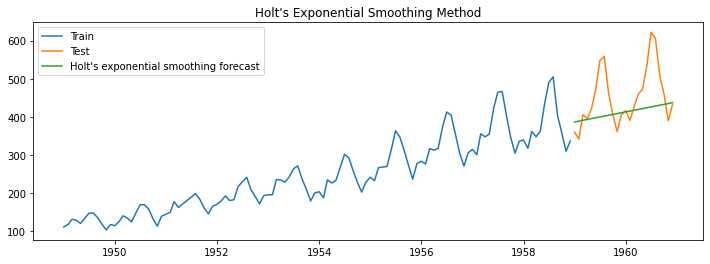

In [25]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [26]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39


## Holt Winters' additive method with trend and seasonality

In [27]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.23610057423053596, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.763899425769464, 'damping_trend': nan, 'initial_level': 119.13352422305572, 'initial_trend': 2.276432727052238, 'initial_seasons': array([ -9.3765948 ,  -3.8814826 ,   8.60809542,   3.51654247,
        -5.17692805,   8.98410398,  21.26633448,  19.34631948,
         5.25601125, -13.59835765, -28.28438932, -12.14479169]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

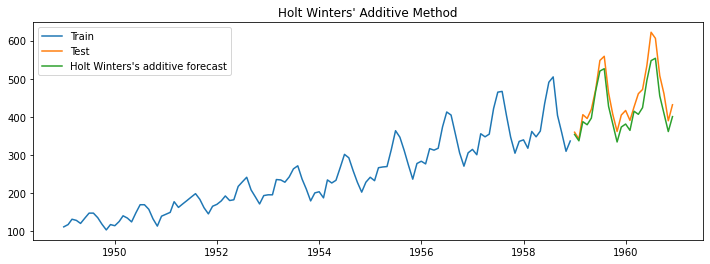

In [28]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [29]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72


## Holt Winter's multiplicative method with trend and seasonality

In [30]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.36559967681918454, 'smoothing_trend': 2.0975361209742212e-10, 'smoothing_seasonal': 0.6344003231245121, 'damping_trend': nan, 'initial_level': 101.1409864748404, 'initial_trend': 2.190647298743001, 'initial_seasons': array([1.08387991, 1.14009268, 1.25315209, 1.19133691, 1.09961029,
       1.20248882, 1.30763758, 1.29876185, 1.18475362, 1.03242514,
       0.9178573 , 1.05893467]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

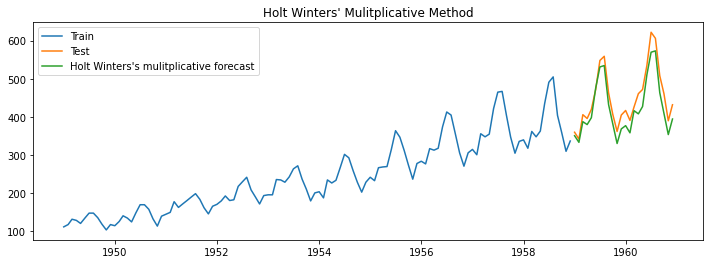

In [31]:
plt.figure(figsize=(12,4))
plt.plot( train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [32]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.45,6.45


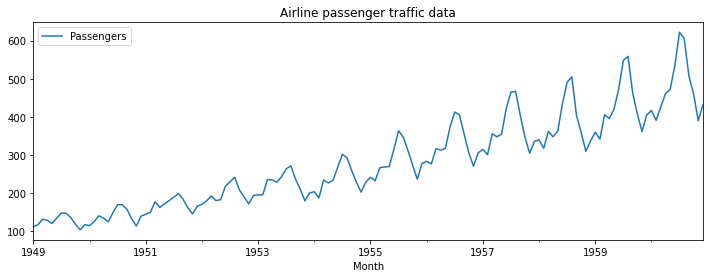

In [33]:
data['Passengers'].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show()

- Visually it's clear that there is a upward trend which means it's not stationary in nature

###  Augmented Dickey-Fuller Test

### ADF(Augmented Dickey Fuller Test)

In [34]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Passengers'])
print(adf_test)

(0.8946087940823935, 0.9930195647605925, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 993.7736365973918)


In [35]:
print('ADF statistic: %f' % adf_test[0])
print('Critical Value @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %.2f' % adf_test[1])

ADF statistic: 0.894609
Critical Value @ 0.05: -2.88
p-value: 0.99


### KPSS Test

In [36]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Passengers'])
print(kpss_test)

(1.651189746942162, 0.01, 8, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [37]:
print('KPSS statistic: %f' % kpss_test[0])
print('Critical Value @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %.2f' % kpss_test[1])

KPSS statistic: 1.651190
Critical Value @ 0.05: 0.46
p-value: 0.01


### Box-Cox Transformation

In [38]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda = 0), index=data.index)

In [39]:
data_boxcox

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Length: 144, dtype: float64

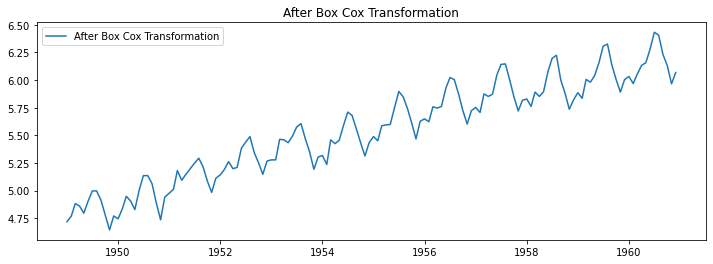

In [40]:
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label = 'After Box Cox Transformation')
plt.legend(loc='best')
plt.title('After Box Cox Transformation')
plt.show()

- The fluctuations throughout the year for different seasons have become almost same. which means the variance problem has been solved.
- The only trend which is present now can be removed by differencing.

### Differencing

In [41]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index=data.index)
data_boxcox_diff

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Length: 144, dtype: float64

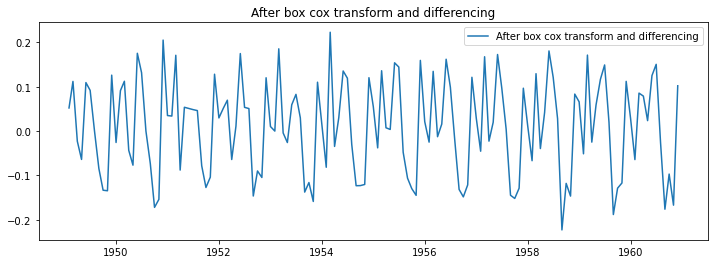

In [42]:
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After box cox transform and differencing')
plt.legend(loc='best')
plt.title('After box cox transform and differencing')
plt.show()

- This visualisation is depicting that the mean is almost 0 i.e, we have achieved constant mean and also the variance became constant throughout. So we got a Stationary Series.

- Now running ADF test and KPSS Test on this transformed series to check if statistically it really has achieved stationarity or not.

### ADF Test

In [43]:
adf_test_boxcox = adfuller(data_boxcox_diff)
print(adf_test_boxcox)

(-3.2901138184594028, 0.015326212237944914, 12, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, -438.57103816956396)


In [44]:
print('ADF statistic: %f' % adf_test_boxcox[0])
print('Critical Value @ 0.05: %.2f' % adf_test_boxcox[4]['5%'])
print('p-value: %f' % adf_test_boxcox[1])

ADF statistic: -3.290114
Critical Value @ 0.05: -2.88
p-value: 0.015326


- p-value is lower than 0.05 and ADF test statistic is also lower than the critical value. which proves that we are rejecting the null hypothesis , so the series is stationary.

### KPSS Test

In [45]:
kpss_test_boxcox = kpss(data_boxcox_diff)
print(kpss_test_boxcox)

(0.03834116415771789, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [46]:
print('KPSS statistic: %f' % kpss_test_boxcox[0])
print('Critical Value @ 0.05: %.2f' % kpss_test_boxcox[3]['5%'])
print('p-value: %.2f' % kpss_test_boxcox[1])

KPSS statistic: 0.038341
Critical Value @ 0.05: 0.46
p-value: 0.10


- The p-value is 0.1 which is greater than 0.05, i.e, the Null Hypothesis is accepted. The series is Stationary.

### Autocorrelation Plot(ACF)

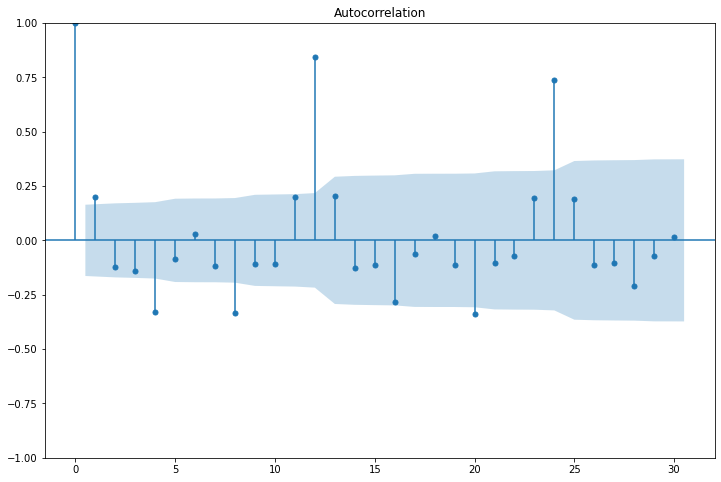

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_diff ,lags=30)
plt.show()

### Partial Autocorrelation Plot(PACF)

<Figure size 864x288 with 0 Axes>

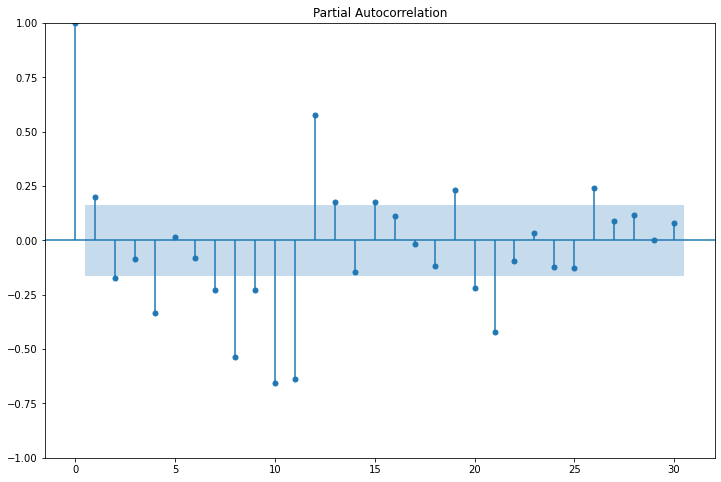

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, lags=30)
plt.show()

## Split into Train and Test datasets

In [49]:
data_boxcox

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Length: 144, dtype: float64

In [50]:
data_boxcox_diff

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Length: 143, dtype: float64

In [51]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_box_diff = data_boxcox_diff[train_len-1:]

### Auto Regression Method(AR)

In [52]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1,0,0))  # building an AR(1) model
model_fit = model.fit()
print(model_fit.params)

const     0.009473
ar.L1     0.183106
sigma2    0.010680
dtype: float64


C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [53]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  119
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 101.219
Date:                Sat, 17 Aug 2024   AIC                           -196.439
Time:                        11:34:44   BIC                           -188.102
Sample:                    02-01-1949   HQIC                          -193.053
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.013      0.715      0.475      -0.017       0.035
ar.L1          0.1831      0.105      1.746      0.081      -0.022       0.389
sigma2         0.0107      0.002      5.488      0.0

In [54]:
# model = ARIMA(train_data_boxcox_diff, order=(4,0,0))  # building an AR(1) model
# model_fit = model.fit()
# print(model_fit.params)
# print(model_fit.summary())

In [55]:
data_boxcox_diff

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Length: 143, dtype: float64

In [56]:
type(data_boxcox_diff)

pandas.core.series.Series

In [57]:
data_boxcox

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Length: 144, dtype: float64

In [58]:
data_boxcox_df = pd.DataFrame(data_boxcox, columns = ['Boxcox Transfrmed Value'])

In [59]:
data_boxcox_df

,Boxcox Transfrmed Value
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


In [60]:
data_boxcox_diff_df = pd.DataFrame(data_boxcox_diff,columns=['Difference Value'])

In [61]:
data_boxcox_diff_df

,Difference Value
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [62]:
data_boxcox_diff_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 1949-02-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Difference Value  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [63]:
data_boxcox_diff_df.shape

(143, 1)

In [64]:
print(data_boxcox_diff.index.min(),'\n',data_boxcox_diff.index.max())

1949-02-01 00:00:00 
 1960-12-01 00:00:00


### Recover Original time series forecast

In [65]:
# y_hat_ar = data_boxcox_diff.copy()
# y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(
# ), data_boxcox_diff.index.max())

# y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()

# y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])

# y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


In [66]:
y_hat_ar_df = data_boxcox_diff_df.copy()
y_hat_ar_df['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff_df.index.min(), data_boxcox_diff_df.index.max())  
# Actual Predictions happens here
# data_boxcox_diff.index.min(), data_boxcox_diff.index.max() i.e. we need to pass the range for which we want to predict
# data_boxcox_diff.index.min() -> FEB 1949
# data_boxcox_diff.index.max() -> DEC 1960

# This forecast is not very useful as it is in a transformed state
# There we need to get back original forecast i.e. the one which we had before transformation

y_hat_ar_df['ar_forecast_boxcox'] = y_hat_ar_df['ar_forecast_boxcox_diff'].cumsum()
# y_hat_ar['ar_forecast_boxcox_diff'].cumsum() -> It keeps adding all the previous values in order to get the individual
# elements in the cumsum. We do this because we want to do opposite of differencing

# Below is an additional step
# We need to add the first term after the box cox transformations because
# when we differenced it, the first intercept was lost
# Therefore, we add to each data point the 1st element of data_boxcox
y_hat_ar_df['ar_forecast_boxcox'] = y_hat_ar_df['ar_forecast_boxcox'].add(data_boxcox[0])  
# Adding the First instance of data_boxcox as this was discarded that time.
# This is the AR forecast of the boxcox transformed series

# Now we also need to reverse translate from boxcox transform to original series
y_hat_ar_df['ar_forecast'] = np.exp(y_hat_ar_df['ar_forecast_boxcox'])
# boxcox took log transformations, therefore here we are taking antilog i.e exp

In [67]:
y_hat_ar_df

,Difference Value,ar_forecast_boxcox_diff,ar_forecast_boxcox,ar_forecast
Month,,,,
1949-02-01,0.052186,0.009473,4.727972,113.066048
1949-03-01,0.112117,0.017294,4.745266,115.038438
1949-04-01,-0.022990,0.028268,4.773534,118.336740
1949-05-01,-0.064022,0.003529,4.777063,118.755107
1949-06-01,0.109484,-0.003984,4.773079,118.282916
...,...,...,...,...
1960-08-01,-0.026060,0.009473,6.033611,417.218694
1960-09-01,-0.176399,0.009473,6.043084,421.189902
1960-10-01,-0.097083,0.009473,6.052557,425.198909


In [68]:
data_boxcox_diff[:6]

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
dtype: float64

In [69]:
data_boxcox[:7]

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
1949-06-01    4.905275
1949-07-01    4.997212
dtype: float64

In [70]:
data_boxcox[0]

4.718498871295094

### Plot Train, test and Forecast

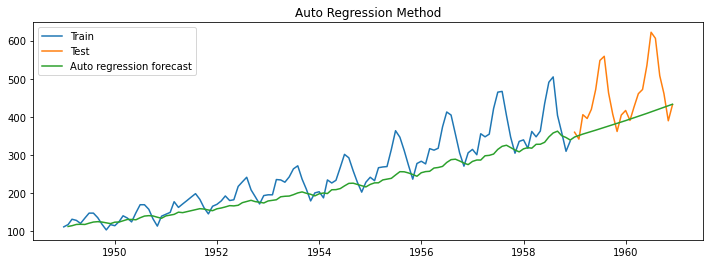

In [71]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar_df['ar_forecast'], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

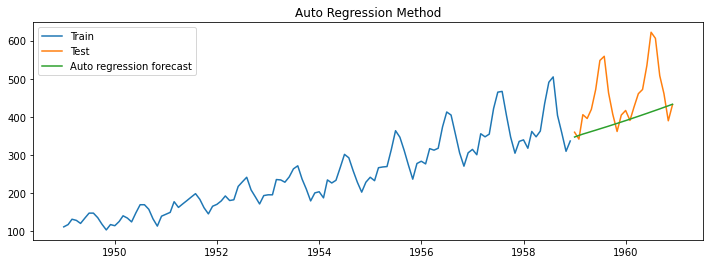

In [72]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ar_df['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [73]:
test['Passengers']

Month
1959-01-01    360.0
1959-02-01    342.0
1959-03-01    406.0
1959-04-01    396.0
1959-05-01    420.0
1959-06-01    472.0
1959-07-01    548.0
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
1960-01-01    417.0
1960-02-01    391.0
1960-03-01    426.0
1960-04-01    461.0
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers, dtype: float64

In [74]:
test.index.min()

Timestamp('1959-01-01 00:00:00')

In [75]:
y_hat_ar_df['ar_forecast'][test.index.min():]

Month
1959-01-01    347.435692
1959-02-01    351.614415
1959-03-01    355.122558
1959-04-01    358.532555
1959-05-01    361.950687
1959-06-01    365.396858
1959-07-01    368.874999
1959-08-01    372.386093
1959-09-01    375.930578
1959-10-01    379.508795
1959-11-01    383.121070
1959-12-01    386.767727
1960-01-01    390.449094
1960-02-01    394.165502
1960-03-01    397.917283
1960-04-01    401.704775
1960-05-01    405.528317
1960-06-01    409.388253
1960-07-01    413.284928
1960-08-01    417.218694
1960-09-01    421.189902
1960-10-01    425.198909
1960-11-01    429.246075
1960-12-01    433.331764
Name: ar_forecast, dtype: float64

### RMSE and MAPE

In [76]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ar_df['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ar_df['ar_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.45,6.45
0,Autoregressive (AR) method,93.49,13.78


### Moving Average (MA)

In [77]:
model = ARIMA(train_data_boxcox_diff, order = (0,0,1))
model_fit = model.fit()
print(model_fit.summary())
print("###################################")
print(model_fit.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  119
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 102.126
Date:                Sat, 17 Aug 2024   AIC                           -198.252
Time:                        11:34:44   BIC                           -189.915
Sample:                    02-01-1949   HQIC                          -194.866
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.013      0.746      0.455      -0.015       0.035
ma.L1          0.2661      0.114      2.333      0.020       0.043       0.490
sigma2         0.0105      0.002      5.549      0.0

C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Recover Original Series Forecast

In [78]:
y_hat_ma = data_boxcox_diff_df.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(
    data_boxcox_diff_df.index.min(), data_boxcox_diff_df.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(
    data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

In [79]:
y_hat_ma

,Difference Value,ma_forecast_boxcox_diff,ma_forecast_boxcox,ma_forecast
Month,,,,
1949-02-01,0.052186,0.009533,4.728032,113.072815
1949-03-01,0.112117,0.020132,4.748164,115.372313
1949-04-01,-0.022990,0.033896,4.782061,119.350019
1949-05-01,-0.064022,-0.005599,4.776461,118.683635
1949-06-01,0.109484,-0.006013,4.770449,117.972162
...,...,...,...,...
1960-08-01,-0.026060,0.009533,6.042221,420.826620
1960-09-01,-0.176399,0.009533,6.051754,424.857594
1960-10-01,-0.097083,0.009533,6.061287,428.927179


### Train, Test and Forecast

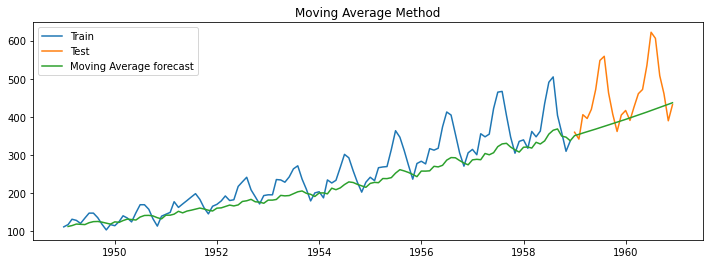

In [80]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ma['ma_forecast'], label='Moving Average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

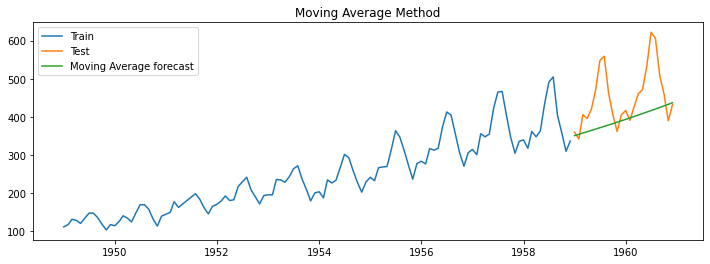

In [81]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving Average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### RMSE and MAPE

In [82]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.45,6.45
0,Autoregressive (AR) method,93.49,13.78
0,Moving Average (MA) method,91.35,13.41


In [83]:
test['Passengers']

Month
1959-01-01    360.0
1959-02-01    342.0
1959-03-01    406.0
1959-04-01    396.0
1959-05-01    420.0
1959-06-01    472.0
1959-07-01    548.0
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
1960-01-01    417.0
1960-02-01    391.0
1960-03-01    426.0
1960-04-01    461.0
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers, dtype: float64

In [84]:
test.index.min()

Timestamp('1959-01-01 00:00:00')

In [85]:
y_hat_ma['ma_forecast'][test.index.min():]

Month
1959-01-01    351.107227
1959-02-01    354.470379
1959-03-01    357.865745
1959-04-01    361.293635
1959-05-01    364.754360
1959-06-01    368.248234
1959-07-01    371.775575
1959-08-01    375.336703
1959-09-01    378.931942
1959-10-01    382.561618
1959-11-01    386.226063
1959-12-01    389.925608
1960-01-01    393.660589
1960-02-01    397.431347
1960-03-01    401.238225
1960-04-01    405.081567
1960-05-01    408.961723
1960-06-01    412.879046
1960-07-01    416.833892
1960-08-01    420.826620
1960-09-01    424.857594
1960-10-01    428.927179
1960-11-01    433.035745
1960-12-01    437.183666
Name: ma_forecast, dtype: float64

### Auto Regressive Moving Average(ARMA) Method

In [86]:
model = ARIMA(train_data_boxcox_diff, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())
print("#########################################")
print(model_fit.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 104.725
Date:                Sat, 17 Aug 2024   AIC                           -201.451
Time:                        11:34:45   BIC                           -190.334
Sample:                    02-01-1949   HQIC                          -196.937
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.011      0.842      0.400      -0.013       0.032
ar.L1         -0.5271      0.206     -2.557      0.011      -0.931      -0.123
ma.L1          0.7983      0.133      5.988      0.0

C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Recover Original Series Forecast

In [87]:
print(data_boxcox_diff_df.index.min(),'\n',data_boxcox_diff_df.index.max())

1949-02-01 00:00:00 
 1960-12-01 00:00:00


In [88]:
y_hat_arma = data_boxcox_diff_df.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff_df.index.min(), data_boxcox_diff_df.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

In [89]:
y_hat_arma

,Difference Value,arma_forecast_boxcox_diff,arma_forecast_boxcox,arma_forecast
Month,,,,
1949-02-01,0.052186,0.009618,4.728116,113.082359
1949-03-01,0.112117,0.018021,4.746137,115.138692
1949-04-01,-0.022990,0.026529,4.772666,118.234025
1949-05-01,-0.064022,-0.011372,4.761294,116.897117
1949-06-01,0.109484,0.007299,4.768594,117.753518
...,...,...,...,...
1960-08-01,-0.026060,0.009617,6.051511,424.754497
1960-09-01,-0.176399,0.009618,6.061129,428.859363
1960-10-01,-0.097083,0.009617,6.070746,433.003789


### Train, Test and Forecast

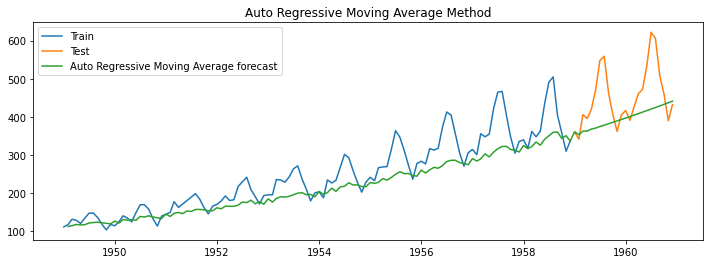

In [90]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arma['arma_forecast'], label='Auto Regressive Moving Average forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Moving Average Method')
plt.show()

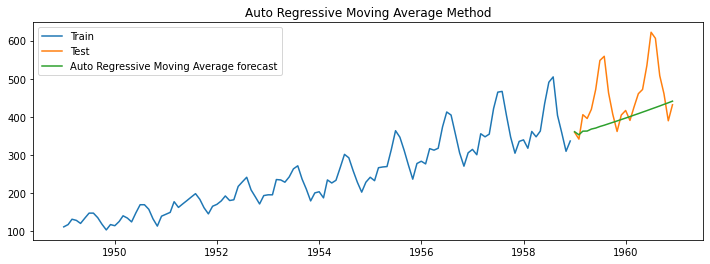

In [91]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='Auto Regressive Moving Average forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Moving Average Method')
plt.show()

### RMSE and MAPE

In [92]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arma['arma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arma['arma_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive Moving Average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.45,6.45
0,Autoregressive (AR) method,93.49,13.78
0,Moving Average (MA) method,91.35,13.41
0,Auto Regressive Moving Average (ARMA) method,89.06,12.91


### ARIMA (Auto Regressive Integrated Moving Average Method)

In [93]:
model = ARIMA(train_data_boxcox, order=(1,1,1), trend = 't')
model_fit = model.fit()
print(model_fit.summary())
print("###########################################")
print(model_fit.params)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 104.725
Date:                Sat, 17 Aug 2024   AIC                           -201.451
Time:                        11:34:45   BIC                           -190.334
Sample:                    01-01-1949   HQIC                          -196.937
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0096      0.011      0.843      0.399      -0.013       0.032
ar.L1         -0.5271      0.206     -2.557      0.011      -0.931      -0.123
ma.L1          0.7983      0.133      5.987      0.0

C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Recover Original Time Series Forecast

In [94]:
print(data_boxcox_df.index.min(),'\n',data_boxcox_df.index.max())

1949-01-01 00:00:00 
 1960-12-01 00:00:00


In [96]:
data_boxcox

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Length: 144, dtype: float64

In [97]:
data_boxcox_df

,Boxcox Transfrmed Value
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


In [98]:
y_hat_arima = data_boxcox_df.copy()   ##### Forecasting the series which doesn't have differenced term

y_hat_arima['arima_forecast_boxcox'] = model_fit.predict(data_boxcox_df.index.min(), data_boxcox_df.index.max())
#y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
#y_hat_arima

#y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])
y_hat_arima

,Boxcox Transfrmed Value,arima_forecast_boxcox,arima_forecast
Month,,,
1949-01-01,4.718499,0.009618,1.009665
1949-02-01,4.770685,4.728117,113.082459
1949-03-01,4.882802,4.788706,120.145745
1949-04-01,4.859812,4.909329,135.548472
1949-05-01,4.795791,4.848444,127.541726
...,...,...,...
1960-08-01,6.406880,6.052118,425.012217
1960-09-01,6.230481,6.061736,429.119946
1960-10-01,6.133398,6.071355,433.267267


In [99]:
data_boxcox_df.iloc[[0]]

,Boxcox Transfrmed Value
Month,
1949-01-01,4.718499


In [100]:
data_boxcox_df.index.min()

Timestamp('1949-01-01 00:00:00')

In [101]:
data_boxcox_diff_df

,Difference Value
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [102]:
y_hat_arima_diff = data_boxcox_diff_df.copy()
y_hat_arima_diff['arima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff_df.index.min(), data_boxcox_diff_df.index.max())
#y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
#y_hat_arima

#y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima_diff['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])
y_hat_arima_diff

,Difference Value,arima_forecast_boxcox,arima_forecast
Month,,,
1949-02-01,0.052186,4.728117,113.082459
1949-03-01,0.112117,4.788706,120.145745
1949-04-01,-0.022990,4.909329,135.548472
1949-05-01,-0.064022,4.848444,127.541726
1949-06-01,0.109484,4.803091,121.886613
...,...,...,...
1960-08-01,-0.026060,6.052118,425.012217
1960-09-01,-0.176399,6.061736,429.119946
1960-10-01,-0.097083,6.071355,433.267267


In [103]:
y_hat_arima

,Boxcox Transfrmed Value,arima_forecast_boxcox,arima_forecast
Month,,,
1949-01-01,4.718499,0.009618,1.009665
1949-02-01,4.770685,4.728117,113.082459
1949-03-01,4.882802,4.788706,120.145745
1949-04-01,4.859812,4.909329,135.548472
1949-05-01,4.795791,4.848444,127.541726
...,...,...,...
1960-08-01,6.406880,6.052118,425.012217
1960-09-01,6.230481,6.061736,429.119946
1960-10-01,6.133398,6.071355,433.267267


In [100]:
test['Passengers']

Month
1959-01-01    360.0
1959-02-01    342.0
1959-03-01    406.0
1959-04-01    396.0
1959-05-01    420.0
1959-06-01    472.0
1959-07-01    548.0
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
1960-01-01    417.0
1960-02-01    391.0
1960-03-01    426.0
1960-04-01    461.0
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers, dtype: float64

In [101]:
y_hat_arima['arima_forecast'][test.index.min():]

Month
1959-01-01    361.505649
1959-02-01    353.528955
1959-03-01    363.004383
1959-04-01    363.275454
1959-05-01    368.505741
1959-06-01    371.151236
1959-07-01    375.225579
1959-08-01    378.592666
1959-09-01    382.389718
1959-10-01    386.011972
1959-11-01    389.781798
1959-12-01    393.528153
1960-01-01    397.342598
1960-02-01    401.176941
1960-03-01    405.057373
1960-04-01    408.970503
1960-05-01    412.924010
1960-06-01    416.914365
1960-07-01    420.944011
1960-08-01    425.012217
1960-09-01    429.119946
1960-10-01    433.267267
1960-11-01    437.454729
1960-12-01    441.682631
Name: arima_forecast, dtype: float64

In [102]:
y_hat_arima_diff['arima_forecast'][test.index.min():].head()

Month
1959-01-01    361.505649
1959-02-01    353.528955
1959-03-01    363.004383
1959-04-01    363.275454
1959-05-01    368.505741
Name: arima_forecast, dtype: float64

### Train, test and Forecast

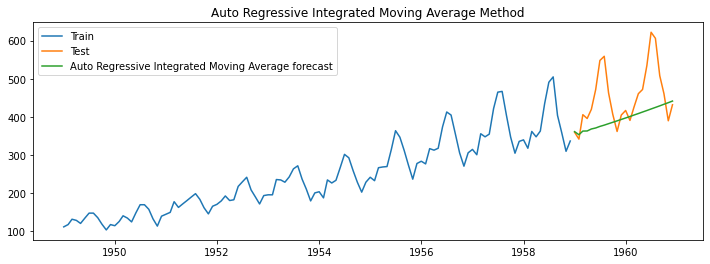

In [103]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='Auto Regressive Integrated Moving Average forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Integrated Moving Average Method')
plt.show()

### RMSE and MAPE

In [104]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_arima['arima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regressive Integrated Moving Average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.45,6.45
0,Autoregressive (AR) method,93.49,13.78
0,Moving Average (MA) method,91.35,13.41
0,Auto Regressive Moving Average (ARMA) method,89.06,12.91


### Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [106]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.params)

C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ar.L1       0.392176
ma.L1      -0.682445
ar.S.L12   -0.037964
ma.S.L12   -0.519466
sigma2      0.001406
dtype: float64


### Recover Original Time Series Forecast

In [107]:
y_hat_sarima = data_boxcox_df.copy()   ##### Forecasting the series which doesn't have differenced term

y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_df.index.min(), data_boxcox_df.index.max())
#y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
#y_hat_arima

#y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima

,Boxcox Transfrmed Value,sarima_forecast_boxcox,sarima_forecast
Month,,,
1949-01-01,4.718499,0.000000,1.000000
1949-02-01,4.770685,4.718499,112.000000
1949-03-01,4.882802,4.770685,118.000000
1949-04-01,4.859812,4.882802,132.000000
1949-05-01,4.795791,4.859812,129.000000
...,...,...,...
1960-08-01,6.406880,6.321427,556.366493
1960-09-01,6.230481,6.146271,466.972667
1960-10-01,6.133398,6.014411,409.284793


In [108]:
test['Passengers']

Month
1959-01-01    360.0
1959-02-01    342.0
1959-03-01    406.0
1959-04-01    396.0
1959-05-01    420.0
1959-06-01    472.0
1959-07-01    548.0
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
1960-01-01    417.0
1960-02-01    391.0
1960-03-01    426.0
1960-04-01    461.0
1960-05-01    472.0
1960-06-01    535.0
1960-07-01    622.0
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers, dtype: float64

In [109]:
y_hat_sarima['sarima_forecast'][test.index.min():]

Month
1959-01-01    349.233717
1959-02-01    334.109477
1959-03-01    387.177340
1959-04-01    377.011915
1959-05-01    387.520915
1959-06-01    459.034374
1959-07-01    513.141958
1959-08-01    517.084828
1959-09-01    434.827101
1959-10-01    380.904019
1959-11-01    332.156083
1959-12-01    367.406909
1960-01-01    377.546527
1960-02-01    359.821905
1960-03-01    416.209440
1960-04-01    404.900380
1960-05-01    416.345030
1960-06-01    493.360259
1960-07-01    551.701329
1960-08-01    556.366493
1960-09-01    466.972667
1960-10-01    409.284793
1960-11-01    356.771601
1960-12-01    394.374789
Name: sarima_forecast, dtype: float64

### Train, Test and Forecast

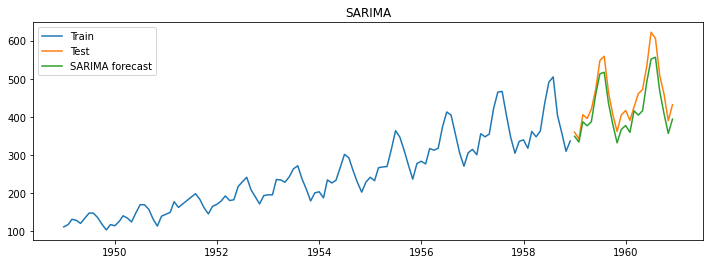

In [110]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA')
plt.show()

### RMSE and MAPE

In [111]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMA Method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.45,6.45
0,Autoregressive (AR) method,93.49,13.78
0,Moving Average (MA) method,91.35,13.41
0,Auto Regressive Moving Average (ARMA) method,89.06,12.91


### Seasonal Autoregressive Integrated Moving Average with External Variables (SARIMAX)

In [112]:
promo = pd.read_csv("promotion.csv", header=None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format="%Y-%m")
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


In [113]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [122]:
print(train_data_boxcox.index.min(),'\n',train_data_boxcox.index.max())

1949-01-01 00:00:00 
 1958-12-01 00:00:00


In [114]:
model = SARIMAX(train_data_boxcox, order=(1,1,1),seasonal_order=(1,1,1,12), exog=promo_train)
model_fit = model.fit()
print(model_fit.params)

C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\RAJDEEP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Event       0.034413
ar.L1       0.487027
ma.L1      -0.748000
ar.S.L12   -0.061829
ma.S.L12   -0.560449
sigma2      0.001334
dtype: float64


### Recover Original Time Series Forecast

In [116]:
test

,Passengers
Month,
1959-01-01,360.0
1959-02-01,342.0
1959-03-01,406.0
1959-04-01,396.0
1959-05-01,420.0
1959-06-01,472.0
1959-07-01,548.0
1959-08-01,559.0
1959-09-01,463.0


In [120]:
print(test.index.min(),'\n',
test.index.max())

1959-01-01 00:00:00 
 1960-12-01 00:00:00


In [126]:
print(promo_test.index.min(),'\n',promo_test.index.max())

1959-01-01 00:00:00 
 1960-12-01 00:00:00


In [127]:
print(promo.index.min(),'\n',promo.index.max())

1949-01-01 00:00:00 
 1960-12-01 00:00:00


In [121]:
print(data_boxcox_df.index.min(),'\n',data_boxcox_df.index.max())

1949-01-01 00:00:00 
 1960-12-01 00:00:00


In [130]:
y_hat_sarimax = data_boxcox_df.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_df.index.min(), data_boxcox_df.index.max()
                                                            ,exog=promo_test)

y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])
y_hat_sarimax

,Boxcox Transfrmed Value,sarimax_forecast_boxcox,sarimax_forecast
Month,,,
1949-01-01,4.718499,0.000000,1.000000
1949-02-01,4.770685,4.718499,112.000000
1949-03-01,4.882802,4.770685,118.000000
1949-04-01,4.859812,4.882802,132.000000
1949-05-01,4.795791,4.859812,129.000000
...,...,...,...
1960-08-01,6.406880,6.332807,562.733854
1960-09-01,6.230481,6.196757,491.153715
1960-10-01,6.133398,6.064424,430.274915


In [131]:
y_hat_sarimax_1 = data_boxcox_df.copy()
y_hat_sarimax_1['sarimax_forecast_boxcox'] = model_fit.predict(test.index.min(), data_boxcox_df.index.max()
                                                            ,exog=promo_test)

y_hat_sarimax_1['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])
y_hat_sarimax_1

,Boxcox Transfrmed Value,sarimax_forecast_boxcox,sarimax_forecast
Month,,,
1949-01-01,4.718499,NaN,1.000000
1949-02-01,4.770685,NaN,112.000000
1949-03-01,4.882802,NaN,118.000000
1949-04-01,4.859812,NaN,132.000000
1949-05-01,4.795791,NaN,129.000000
...,...,...,...
1960-08-01,6.406880,6.332807,562.733854
1960-09-01,6.230481,6.196757,491.153715
1960-10-01,6.133398,6.064424,430.274915


### Plot Train, Test, Forecast

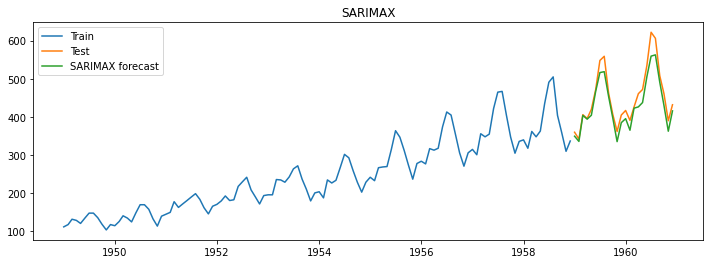

In [132]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX')
plt.show()

### MAPE and RMSE

In [135]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['SARIMAX Method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,137.51,23.63
0,Simple average method,219.69,44.28
0,Simple moving average forecast,103.33,15.54
0,Simple exponential smoothing forecast,107.65,16.49
0,Holt's exponential smoothing method,80.91,11.39
0,Holt Winters' additive method,35.87,6.72
0,Holt Winters' multiplicative method,32.45,6.45
0,Autoregressive (AR) method,93.49,13.78
0,Moving Average (MA) method,91.35,13.41
0,Auto Regressive Moving Average (ARMA) method,89.06,12.91
